# Setup and data loading

In [1]:
import os
from tqdm import tqdm
import torch
import gc
import numpy as np
from torch.utils.data import DataLoader
from monai.data import Dataset, DataLoader, CacheDataset
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd,
    Orientationd, ScaleIntensityd, EnsureTyped, Resized, CenterSpatialCropd
)
from monai.utils import set_determinism

set_determinism(seed=42)  # Set random seed for deterministic training

# Define data directories
ad_dir, cn_dir = os.path.join("data/AD"), os.path.join("data/CN")

# Prepare data for training and validation
def get_file_list(data_path, label):
    return [{"image": os.path.join(data_path, f), "label": label} for f in os.listdir(data_path) if f.endswith(".nii")]

data_list = get_file_list(ad_dir, 1) + get_file_list(cn_dir, 0)
np.random.shuffle(data_list)

# Split into training and validation sets (20/80 split)
n_val = int(len(data_list) * 0.2)  # Get the number of validation samples (20%)
train_data, val_data = data_list[:-n_val], data_list[-n_val:]  # Slice the list

roi_size = (96, 96, 50)

# Define basic transforms (no augmentation)
train_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    CenterSpatialCropd(keys=["image"], roi_size=roi_size),  # Crop the middle 50 slices
    #Resized(keys=["image"], spatial_size=(96, 96, 96)),  # Resize after cropping
    Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
    Orientationd(keys=["image"], axcodes="RAS"),
    ScaleIntensityd(keys=["image"]),
    EnsureTyped(keys=["image"]),
])

val_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    CenterSpatialCropd(keys=["image"], roi_size=roi_size),  # Crop the middle 50 slices
    #Resized(keys=["image"], spatial_size=(96, 96, 96)),  # Resize after cropping
    Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
    Orientationd(keys=["image"], axcodes="RAS"),
    ScaleIntensityd(keys=["image"]),
    EnsureTyped(keys=["image"]),
])

# Create datasets using CacheDataset for caching
train_ds = CacheDataset(data=train_data, transform=train_transforms)
val_ds = CacheDataset(data=val_data, transform=val_transforms)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|███████████████████████████████████████████████████████████████| 196/196 [00:31<00:00,  6.14it/s]


In [2]:
from monai.networks.nets import ResNet

In [3]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize ResNet
model = ResNet(
    block="bottleneck",
    layers = (3, 4, 6, 3), # ResNet-18 -> (2, 2, 2, 2) ResNet-50 -> (3, 4, 6, 3)
    block_inplanes=(64, 128, 256, 512),
    spatial_dims=3,
    n_input_channels=1,
    num_classes=2
).to(device)

# Loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [4]:
device

device(type='cuda')

In [5]:
from torchinfo import summary
summary(model, input_size=(1, 1, 96, 96, 96))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv3d: 1-1                            [1, 64, 96, 96, 96]       21,952
├─BatchNorm3d: 1-2                       [1, 64, 96, 96, 96]       128
├─ReLU: 1-3                              [1, 64, 96, 96, 96]       --
├─MaxPool3d: 1-4                         [1, 64, 48, 48, 48]       --
├─Sequential: 1-5                        [1, 256, 48, 48, 48]      --
│    └─ResNetBottleneck: 2-1             [1, 256, 48, 48, 48]      --
│    │    └─Conv3d: 3-1                  [1, 64, 48, 48, 48]       4,096
│    │    └─BatchNorm3d: 3-2             [1, 64, 48, 48, 48]       128
│    │    └─ReLU: 3-3                    [1, 64, 48, 48, 48]       --
│    │    └─Conv3d: 3-4                  [1, 64, 48, 48, 48]       110,592
│    │    └─BatchNorm3d: 3-5             [1, 64, 48, 48, 48]       128
│    │    └─ReLU: 3-6                    [1, 64, 48, 48, 48]       --


# Training loop and validation evaluation loop

In [6]:
epochs = 20
best_metric, best_metric_epoch = -1, -1

# Lists to store loss and accuracy for plotting
train_losses = []
val_losses = []
val_accuracies = []

print(f"Training on {len(train_data)} samples, validating on {len(val_data)} samples.")

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    # Training phase
    model.train()
    epoch_loss = 0
    with tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}", unit="batch") as pbar_train:
        for batch in pbar_train:
            inputs, labels = batch["image"].to(device), batch["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

            # Delete references to tensors that are no longer needed
            del inputs, labels, outputs  
            gc.collect()  # Force garbage collection to free memory
            torch.cuda.empty_cache()  # Free any unused GPU memory

            # Update tqdm progress bar description
            pbar_train.set_postfix(loss=loss.item(), epoch_loss=epoch_loss / len(train_loader))
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Training loss: {avg_train_loss:.4f}")
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    total_samples = 0
    with torch.inference_mode():
        with tqdm(val_loader, desc=f"Validating Epoch {epoch+1}/{epochs}", unit="batch") as pbar_val:
            for val_batch in pbar_val:
                val_inputs, val_labels = val_batch["image"].to(device), val_batch["label"].to(device)
                val_outputs = model(val_inputs)
                
                val_loss += loss_function(val_outputs, val_labels).item()
                val_correct += (val_outputs.argmax(dim=1) == val_labels).sum().item()
                total_samples += val_labels.size(0)
                
                # Update tqdm progress bar description
                pbar_val.set_postfix(val_loss=val_loss / (total_samples + 1), accuracy=val_correct / total_samples)
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    accuracy = val_correct / total_samples
    val_accuracies.append(accuracy)
    
    print(f"Validation loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Track best accuracy
    if accuracy > best_metric:
        best_metric = accuracy
        best_metric_epoch = epoch + 1

    # Optionally, log memory usage after each epoch
    print(f"Epoch {epoch}, GPU memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"Epoch {epoch}, GPU memory reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

print(f"Training complete. Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
gc.collect()  # Force garbage collection to free memory
torch.cuda.empty_cache()  # Free any unused GPU memory

Training on 788 samples, validating on 196 samples.
Epoch 1/20


Training Epoch 1/20: 100%|██████████████████████████| 197/197 [02:04<00:00,  1.58batch/s, epoch_loss=0.687, loss=0.697]


Training loss: 0.6875


Validating Epoch 1/20: 100%|████████████████████████| 49/49 [00:36<00:00,  1.36batch/s, accuracy=0.612, val_loss=0.169]


Validation loss: 0.6810, Accuracy: 0.6122
Epoch 0, GPU memory allocated: 0.72 GB
Epoch 0, GPU memory reserved: 2.03 GB
Epoch 2/20


Training Epoch 2/20: 100%|████████████████████████████| 197/197 [02:06<00:00,  1.55batch/s, epoch_loss=0.689, loss=0.6]


Training loss: 0.6888


Validating Epoch 2/20: 100%|█████████████████████████| 49/49 [00:35<00:00,  1.37batch/s, accuracy=0.617, val_loss=0.16]


Validation loss: 0.6446, Accuracy: 0.6173
Epoch 1, GPU memory allocated: 0.72 GB
Epoch 1, GPU memory reserved: 2.04 GB
Epoch 3/20


Training Epoch 3/20: 100%|██████████████████████████| 197/197 [02:03<00:00,  1.60batch/s, epoch_loss=0.634, loss=0.834]


Training loss: 0.6340


Validating Epoch 3/20: 100%|████████████████████████| 49/49 [00:35<00:00,  1.36batch/s, accuracy=0.597, val_loss=0.177]


Validation loss: 0.7111, Accuracy: 0.5969
Epoch 2, GPU memory allocated: 0.72 GB
Epoch 2, GPU memory reserved: 2.03 GB
Epoch 4/20


Training Epoch 4/20: 100%|██████████████████████████| 197/197 [02:03<00:00,  1.60batch/s, epoch_loss=0.617, loss=0.383]


Training loss: 0.6167


Validating Epoch 4/20: 100%|████████████████████████| 49/49 [00:35<00:00,  1.37batch/s, accuracy=0.628, val_loss=0.167]


Validation loss: 0.6703, Accuracy: 0.6276
Epoch 3, GPU memory allocated: 0.72 GB
Epoch 3, GPU memory reserved: 2.04 GB
Epoch 5/20


Training Epoch 5/20: 100%|██████████████████████████| 197/197 [02:03<00:00,  1.60batch/s, epoch_loss=0.615, loss=0.451]


Training loss: 0.6146


Validating Epoch 5/20: 100%|████████████████████████| 49/49 [00:35<00:00,  1.37batch/s, accuracy=0.745, val_loss=0.132]


Validation loss: 0.5292, Accuracy: 0.7449
Epoch 4, GPU memory allocated: 0.72 GB
Epoch 4, GPU memory reserved: 2.03 GB
Epoch 6/20


Training Epoch 6/20: 100%|████████████████████████████| 197/197 [02:03<00:00,  1.60batch/s, epoch_loss=0.51, loss=1.02]


Training loss: 0.5100


Validating Epoch 6/20: 100%|████████████████████████| 49/49 [00:35<00:00,  1.37batch/s, accuracy=0.602, val_loss=0.196]


Validation loss: 0.7892, Accuracy: 0.6020
Epoch 5, GPU memory allocated: 0.72 GB
Epoch 5, GPU memory reserved: 2.04 GB
Epoch 7/20


Training Epoch 7/20: 100%|██████████████████████████| 197/197 [02:03<00:00,  1.60batch/s, epoch_loss=0.461, loss=0.163]


Training loss: 0.4612


Validating Epoch 7/20: 100%|████████████████████████| 49/49 [00:35<00:00,  1.36batch/s, accuracy=0.689, val_loss=0.184]


Validation loss: 0.7412, Accuracy: 0.6888
Epoch 6, GPU memory allocated: 0.72 GB
Epoch 6, GPU memory reserved: 2.03 GB
Epoch 8/20


Training Epoch 8/20: 100%|███████████████████████████| 197/197 [02:04<00:00,  1.58batch/s, epoch_loss=0.43, loss=0.191]


Training loss: 0.4304


Validating Epoch 8/20: 100%|████████████████████████| 49/49 [00:35<00:00,  1.37batch/s, accuracy=0.765, val_loss=0.139]


Validation loss: 0.5588, Accuracy: 0.7653
Epoch 7, GPU memory allocated: 0.72 GB
Epoch 7, GPU memory reserved: 2.04 GB
Epoch 9/20


Training Epoch 9/20: 100%|█████████████████████████| 197/197 [02:03<00:00,  1.60batch/s, epoch_loss=0.336, loss=0.0717]


Training loss: 0.3363


Validating Epoch 9/20: 100%|█████████████████████████| 49/49 [00:36<00:00,  1.36batch/s, accuracy=0.75, val_loss=0.131]


Validation loss: 0.5261, Accuracy: 0.7500
Epoch 8, GPU memory allocated: 0.72 GB
Epoch 8, GPU memory reserved: 2.03 GB
Epoch 10/20


Training Epoch 10/20: 100%|█████████████████████████| 197/197 [02:03<00:00,  1.60batch/s, epoch_loss=0.313, loss=0.096]


Training loss: 0.3131


Validating Epoch 10/20: 100%|███████████████████████| 49/49 [00:35<00:00,  1.37batch/s, accuracy=0.837, val_loss=0.106]


Validation loss: 0.4279, Accuracy: 0.8367
Epoch 9, GPU memory allocated: 0.72 GB
Epoch 9, GPU memory reserved: 2.04 GB
Epoch 11/20


Training Epoch 11/20: 100%|█████████████████████████| 197/197 [02:03<00:00,  1.60batch/s, epoch_loss=0.184, loss=0.156]


Training loss: 0.1836


Validating Epoch 11/20: 100%|██████████████████████| 49/49 [00:36<00:00,  1.35batch/s, accuracy=0.842, val_loss=0.0939]


Validation loss: 0.3774, Accuracy: 0.8418
Epoch 10, GPU memory allocated: 0.72 GB
Epoch 10, GPU memory reserved: 2.03 GB
Epoch 12/20


Training Epoch 12/20: 100%|████████████████████████| 197/197 [02:03<00:00,  1.60batch/s, epoch_loss=0.169, loss=0.0259]


Training loss: 0.1687


Validating Epoch 12/20: 100%|███████████████████████| 49/49 [00:36<00:00,  1.36batch/s, accuracy=0.811, val_loss=0.142]


Validation loss: 0.5707, Accuracy: 0.8112
Epoch 11, GPU memory allocated: 0.72 GB
Epoch 11, GPU memory reserved: 2.04 GB
Epoch 13/20


Training Epoch 13/20: 100%|█████████████████████████| 197/197 [02:03<00:00,  1.60batch/s, epoch_loss=0.192, loss=0.308]


Training loss: 0.1921


Validating Epoch 13/20: 100%|██████████████████████| 49/49 [00:35<00:00,  1.37batch/s, accuracy=0.847, val_loss=0.0911]


Validation loss: 0.3663, Accuracy: 0.8469
Epoch 12, GPU memory allocated: 0.72 GB
Epoch 12, GPU memory reserved: 2.03 GB
Epoch 14/20


Training Epoch 14/20: 100%|████████████████████████| 197/197 [02:03<00:00,  1.60batch/s, epoch_loss=0.0714, loss=0.137]


Training loss: 0.0714


Validating Epoch 14/20: 100%|███████████████████████| 49/49 [00:35<00:00,  1.36batch/s, accuracy=0.765, val_loss=0.151]


Validation loss: 0.6065, Accuracy: 0.7653
Epoch 13, GPU memory allocated: 0.72 GB
Epoch 13, GPU memory reserved: 2.04 GB
Epoch 15/20


Training Epoch 15/20: 100%|████████████████████████| 197/197 [02:03<00:00,  1.60batch/s, epoch_loss=0.101, loss=0.0162]


Training loss: 0.1014


Validating Epoch 15/20: 100%|███████████████████████| 49/49 [00:36<00:00,  1.36batch/s, accuracy=0.837, val_loss=0.119]


Validation loss: 0.4785, Accuracy: 0.8367
Epoch 14, GPU memory allocated: 0.72 GB
Epoch 14, GPU memory reserved: 2.03 GB
Epoch 16/20


Training Epoch 16/20: 100%|████████████████████████| 197/197 [02:03<00:00,  1.60batch/s, epoch_loss=0.0752, loss=0.727]


Training loss: 0.0752


Validating Epoch 16/20: 100%|██████████████████████| 49/49 [00:36<00:00,  1.36batch/s, accuracy=0.903, val_loss=0.0924]


Validation loss: 0.3716, Accuracy: 0.9031
Epoch 15, GPU memory allocated: 0.72 GB
Epoch 15, GPU memory reserved: 2.04 GB
Epoch 17/20


Training Epoch 17/20: 100%|██████████████████████| 197/197 [02:03<00:00,  1.60batch/s, epoch_loss=0.0367, loss=0.00451]


Training loss: 0.0367


Validating Epoch 17/20: 100%|███████████████████████| 49/49 [00:35<00:00,  1.36batch/s, accuracy=0.842, val_loss=0.103]


Validation loss: 0.4145, Accuracy: 0.8418
Epoch 16, GPU memory allocated: 0.72 GB
Epoch 16, GPU memory reserved: 2.03 GB
Epoch 18/20


Training Epoch 18/20: 100%|████████████████████████| 197/197 [02:03<00:00,  1.60batch/s, epoch_loss=0.157, loss=0.0812]


Training loss: 0.1567


Validating Epoch 18/20: 100%|██████████████████████| 49/49 [00:36<00:00,  1.36batch/s, accuracy=0.862, val_loss=0.0859]


Validation loss: 0.3455, Accuracy: 0.8622
Epoch 17, GPU memory allocated: 0.72 GB
Epoch 17, GPU memory reserved: 2.04 GB
Epoch 19/20


Training Epoch 19/20: 100%|██████████████████████| 197/197 [02:03<00:00,  1.60batch/s, epoch_loss=0.0685, loss=0.00112]


Training loss: 0.0685


Validating Epoch 19/20: 100%|███████████████████████| 49/49 [00:35<00:00,  1.36batch/s, accuracy=0.862, val_loss=0.107]


Validation loss: 0.4288, Accuracy: 0.8622
Epoch 18, GPU memory allocated: 0.72 GB
Epoch 18, GPU memory reserved: 2.03 GB
Epoch 20/20


Training Epoch 20/20: 100%|███████████████████████| 197/197 [02:03<00:00,  1.59batch/s, epoch_loss=0.0407, loss=0.0265]


Training loss: 0.0407


Validating Epoch 20/20: 100%|███████████████████████| 49/49 [00:36<00:00,  1.36batch/s, accuracy=0.806, val_loss=0.151]

Validation loss: 0.6063, Accuracy: 0.8061
Epoch 19, GPU memory allocated: 0.72 GB
Epoch 19, GPU memory reserved: 2.04 GB
Training complete. Best accuracy: 0.9031 at epoch 16


# Plot Loss and Accuracy Curves

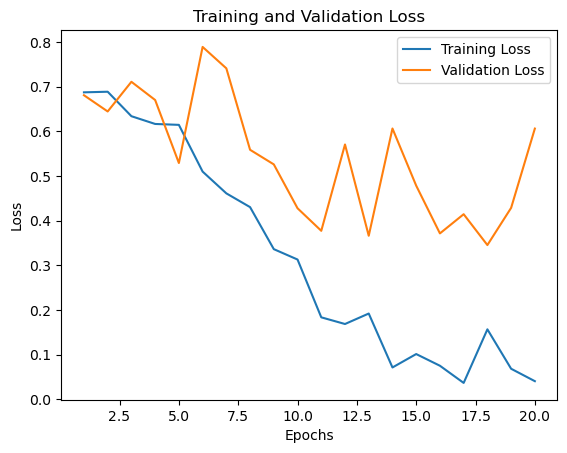

In [17]:
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig("train_and_val_loss.pdf", format="pdf", bbox_inches="tight")
plt.show()

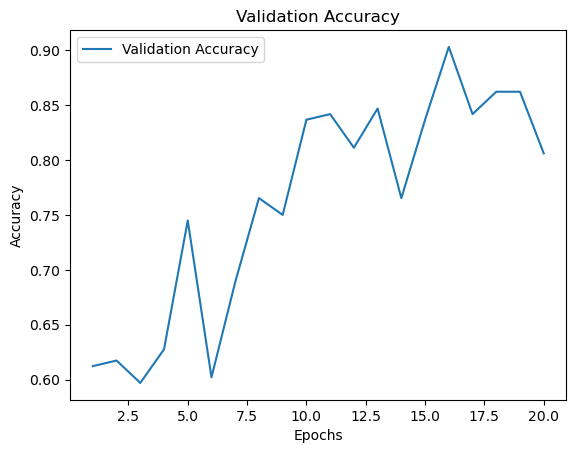

In [18]:
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.savefig("val_accuracy.pdf", format="pdf", bbox_inches="tight")
plt.show()


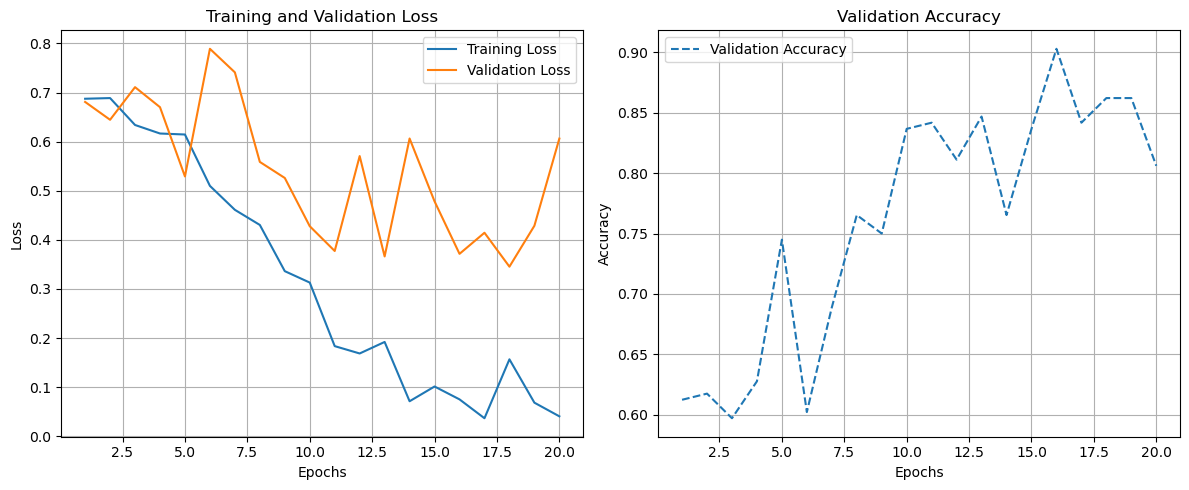

In [26]:
epochs = range(1, len(train_losses) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Subplot 1: Training and Validation Loss
ax1.plot(epochs, train_losses, label='Training Loss')
ax1.plot(epochs, val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid()

# Subplot 2: Validation Accuracy
ax2.plot(epochs, val_accuracies, label='Validation Accuracy', linestyle='--')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid()

# Adjust layout and show the figure
plt.tight_layout()
plt.savefig("train_val_and_accuracy_grid.pdf", format="pdf", bbox_inches="tight")
plt.show()